In [27]:
!cd /Users/yuki.matsumoto/Documents/Project/infonia/分析/notebook/
os.chdir('/Users/yuki.matsumoto/Documents/Project/infonia/分析/notebook/')

In [28]:
!pwd

/Users/yuki.matsumoto/Documents/Project/infonia/分析/notebook


In [29]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import roc_auc_score
sns.set()
%matplotlib inline

import os
from glob import glob
import feather
import os
os.chdir('../../Git/InfoNear/py/eda')
import gc
import sys
import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy

plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'Ricty Diminised'
sns.set(style="whitegrid", font='Ricty Diminised', palette="muted",
        color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

import japanize_matplotlib

import categorical_target_vs_vars_violin_plotter


In [30]:
!pwd

/Users/yuki.matsumoto/Documents/Project/infonia/Git/InfoNear/py/eda


In [4]:
def kesson_table(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    kesson_table = pd.concat([null_val,percent],axis=1)
    kesson_table_ren_columns = kesson_table.rename(columns = {0:'lack num',1:'%'})
    return kesson_table_ren_columns

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
!pwd

/Users/yuki.matsumoto/Documents/Project/infonia/Git/InfoNear/py/eda


In [13]:
root = '/Users/yuki.matsumoto/Documents/Project/infonia/分析/input/winequality/'

winequality_red_df = pd.read_csv(root + 'winequality-red.csv', delimiter=";")
winequality_white_df = pd.read_csv(root + 'winequality-white.csv', delimiter=";")    

In [14]:
print(f'winequality_red_df dataset has {winequality_red_df.shape[0]} rows and {winequality_red_df.shape[1]} columns.')
print(f'winequality_white_df dataset has {winequality_white_df.shape[0]} rows and {winequality_white_df.shape[1]} columns.')

winequality_red_df dataset has 1599 rows and 12 columns.
winequality_white_df dataset has 4898 rows and 12 columns.


In [15]:
display(winequality_red_df.head())
display(winequality_white_df.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [46]:
winequality_red_df["quality"].unique()

array([5, 6, 7, 4, 8, 3])

In [93]:
winequality_red_df["quality"].dtype

dtype('int64')

In [94]:
winequality_red_df["alcohol"].dtype

dtype('float64')

In [96]:
wine_red_df.head()

,alcohol,quality
0,9.4,5
1,9.8,5
2,9.8,5
3,9.8,6
4,9.4,5


ホテリング法：実装

In [74]:
from statistics import mean, variance
from scipy import stats as st
from scipy.spatial import distance

In [100]:
wine_red_df = pd.DataFrame({"alcohol":winequality_red_df["alcohol"],
                                                      "quality":winequality_red_df["quality"]})

# 標本平均
mean = np.mean(wine_red_df, axis=0)
# 標本分散
cov = np.cov(wine_red_df.T)

In [101]:
display(cov)
display(mean)

array([[1.1356474 , 0.40978901],
       [0.40978901, 0.6521684 ]])

alcohol    10.422983
quality     5.636023
dtype: float64

In [102]:
variance(wine_red_df["alcohol"])

1.1356473950004737

In [103]:
mean["alcohol"]

10.422983114446502

In [106]:
stats.chi2.interval(0.99, 1)

(3.927042222051594e-05, 7.879438576622417)

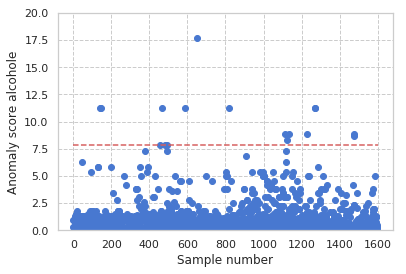

In [112]:
# 異常度
anomaly_scores = []
for x in winequality_red_df["alcohol"]:
    anomaly_score = (x - mean["alcohol"])**2 / variance(wine_red_df["alcohol"])
    anomaly_scores.append(anomaly_score)

# カイ二乗分布による1%水準の閾値
threshold = stats.chi2.interval(0.99, 1)[1]

# 結果の描画
plt.plot(anomaly_scores, "o", color = "b")
plt.plot([0,1600],[threshold, threshold], 'k-', color = "r", ls = "dashed")
plt.xlabel("Sample number")
plt.ylabel("Anomaly score alcohole")
plt.ylim([0,20])
plt.show()

In [114]:
st.chi2.pdf(1-f1,wine_red_df.shape[0])

0.0

In [81]:
f1 = 0.15

# 閾値を設定して下さい
thr = st.chi2.ppf(1-f1,wine_red_df.shape[0])

mah = [distance.mahalanobis(x, mean, np.linalg.pinv(cov)) for x in winequality_red_df["alcohol"]]

In [107]:
thr

1657.6486123669724

In [89]:
# X_err, X_normを分類して下さい
X_err = wine_red_df[mah > thr]
X_nom = wine_red_df[mah <= thr]
print(X_nom)

# # プロットしています
# plt.plot(X_err[:, 0], X_err[:, 1], "o", color="r")
# plt.plot(X_nom[:, 0], X_nom[:, 1], "o", color="b")
# plt.title("T二乗法によるX_testについての異常値検知")
# plt.show()

      alcohol  quality
0         9.4        5
1         9.8        5
2         9.8        5
3         9.8        6
4         9.4        5
5         9.4        5
6         9.4        5
7        10.0        7
8         9.5        7
9        10.5        5
10        9.2        5
11       10.5        5
12        9.9        5
13        9.1        5
14        9.2        5
15        9.2        5
16       10.5        7
17        9.3        5
18        9.0        4
19        9.2        6
20        9.4        6
21        9.7        5
22        9.5        5
23        9.4        5
24        9.7        6
25        9.3        5
26        9.5        5
27        9.5        5
28        9.4        5
29        9.8        6
...       ...      ...
1569     11.5        6
1570     12.4        6
1571     11.1        6
1572      9.5        5
1573     12.5        6
1574     10.5        6
1575     11.8        6
1576     10.8        6
1577     11.9        6
1578     11.3        6
1579     11.3        5
1580     11

In [87]:
# X_err, X_normを分類して下さい
X_err = wine_red_df[mah > thr]
X_nom = wine_red_df[mah <= thr]
print(len(mah))

# # プロットしています
# plt.plot(X_err[:, 0], X_err[:, 1], "o", color="r")
# plt.plot(X_nom[:, 0], X_nom[:, 1], "o", color="b")
# plt.title("T二乗法によるX_testについての異常値検知")
# plt.show()

1599


TypeError: '(slice(None, None, None), 0)' is an invalid key

In [ ]:
# カイ二乗分布による1%水準の閾値
threshold = stats.chi2.interval(0.99, 1)[1]

# 結果の描画
plt.plot(num, anomaly_scores, "o", color = "b")
plt.plot([0,200],[threshold, threshold], 'k-', color = "r", ls = "dashed")
plt.xlabel("Sample number")
plt.ylabel("Anomaly score")
plt.ylim([0,100])
plt.show()